# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [2]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [6]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [7]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = loss_fn(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = loss_fn(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [8]:
embedding_net = EmbeddingNet().to(device)
n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [9]:
for epoch in range(n_epochs):
    
    # Train stage
    train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, loss_fn)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Epoch: 1/10. Train set: Average loss: 1.3192 Accuracy: 53.02
Epoch: 1/10. Validation set: Average loss: 0.8984 Accuracy: 74.52
Epoch: 2/10. Train set: Average loss: 0.7695 Accuracy: 78.67
Epoch: 2/10. Validation set: Average loss: 0.7656 Accuracy: 81.28
Epoch: 3/10. Train set: Average loss: 0.6163 Accuracy: 83.05
Epoch: 3/10. Validation set: Average loss: 0.6034 Accuracy: 83.39
Epoch: 4/10. Train set: Average loss: 0.5186 Accuracy: 85.66
Epoch: 4/10. Validation set: Average loss: 0.6067 Accuracy: 85.30
Epoch: 5/10. Train set: Average loss: 0.4726 Accuracy: 86.98
Epoch: 5/10. Validation set: Average loss: 0.5662 Accuracy: 87.07
Epoch: 6/10. Train set: Average loss: 0.4364 Accuracy: 87.98
Epoch: 6/10. Validation set: Average loss: 0.5529 Accuracy: 87.07
Epoch: 7/10. Train set: Average loss: 0.3899 Accuracy: 88.80
Epoch: 7/10. Validation set: Average loss: 0.5248 Accuracy: 87.62
Epoch: 8/10. Train set: Average loss: 0.3584 Accuracy: 89.70
Epoch: 8/10. Validation set: Average loss: 0.5163 

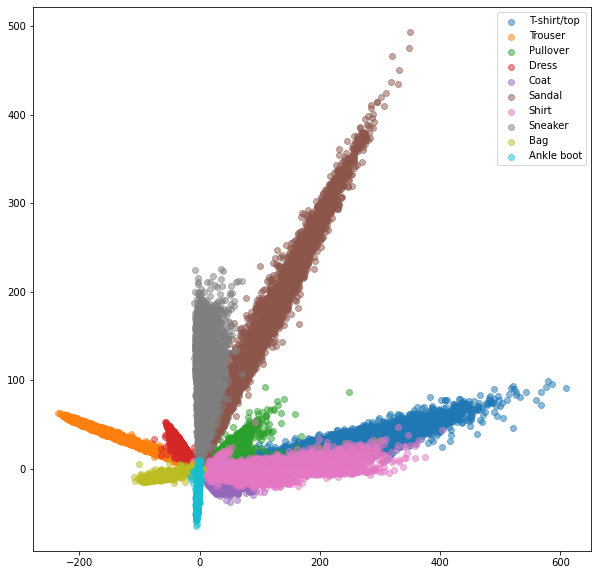

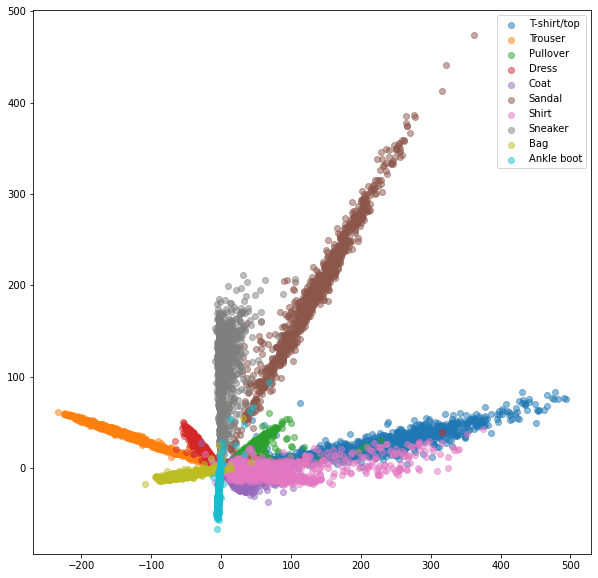

In [10]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [11]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
            
        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through thransform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target

        
    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [12]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

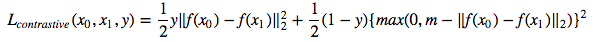

In [13]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [14]:
def train_epoch_siamese(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = loss_fn(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = loss_fn(output1, output2, target)
        val_loss += loss.item()
        
    return val_loss

In [15]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)

batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [16]:
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0508
Epoch: 1/10. Validation set: Average loss: 0.0456
Epoch: 2/10. Train set: Average loss: 0.0396
Epoch: 2/10. Validation set: Average loss: 0.0383
Epoch: 3/10. Train set: Average loss: 0.0350
Epoch: 3/10. Validation set: Average loss: 0.0346
Epoch: 4/10. Train set: Average loss: 0.0319
Epoch: 4/10. Validation set: Average loss: 0.0330
Epoch: 5/10. Train set: Average loss: 0.0293
Epoch: 5/10. Validation set: Average loss: 0.0326
Epoch: 6/10. Train set: Average loss: 0.0278
Epoch: 6/10. Validation set: Average loss: 0.0316
Epoch: 7/10. Train set: Average loss: 0.0266
Epoch: 7/10. Validation set: Average loss: 0.0305
Epoch: 8/10. Train set: Average loss: 0.0250
Epoch: 8/10. Validation set: Average loss: 0.0297
Epoch: 9/10. Train set: Average loss: 0.0215
Epoch: 9/10. Validation set: Average loss: 0.0270
Epoch: 10/10. Train set: Average loss: 0.0201
Epoch: 10/10. Validation set: Average loss: 0.0273


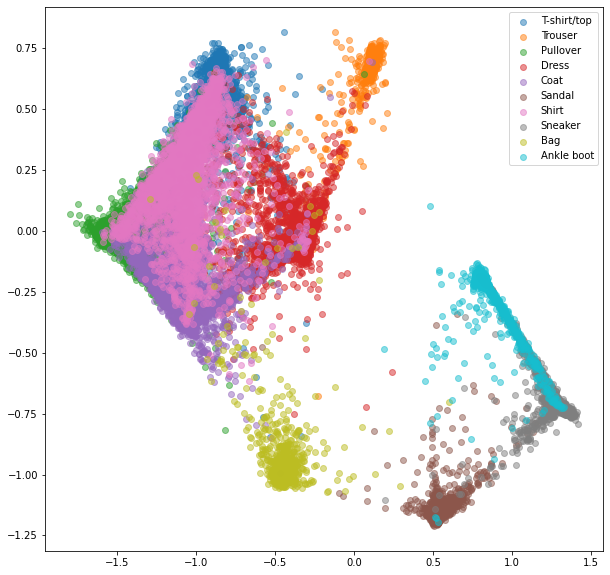

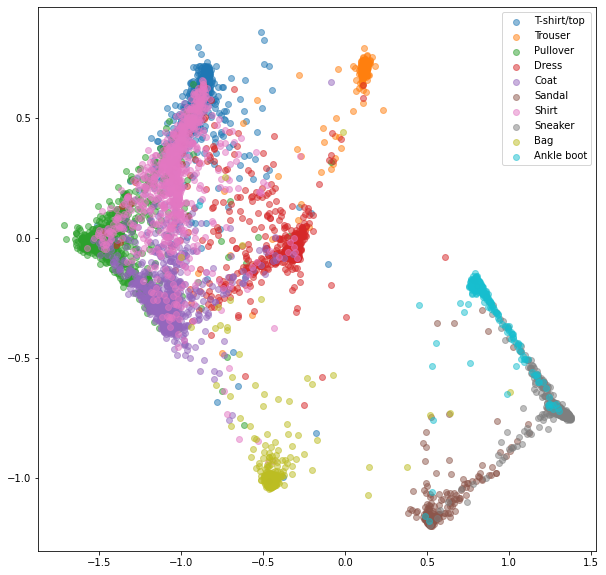

In [17]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings. 

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

In [18]:
!pip install pytorch-metric-learning faiss-gpu

     |████████████████████████████████| 112kB 7.4MB/s 
     |████████████████████████████████| 89.4MB 37kB/s 


In [19]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [20]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [21]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1.)

Epoch 1 Iteration 0: Loss = 0.9393849968910217, Number of mined triplets = 182646
Epoch 1 Iteration 20: Loss = 0.9426430463790894, Number of mined triplets = 97982
Epoch 1 Iteration 40: Loss = 0.9497478604316711, Number of mined triplets = 71755
Epoch 1 Iteration 60: Loss = 0.9072340726852417, Number of mined triplets = 57275
Epoch 1 Iteration 80: Loss = 1.0339748859405518, Number of mined triplets = 56487
Epoch 1 Iteration 100: Loss = 0.9778144955635071, Number of mined triplets = 51393
Epoch 1 Iteration 120: Loss = 0.9582251310348511, Number of mined triplets = 60643
Epoch 1 Iteration 140: Loss = 1.05307137966156, Number of mined triplets = 40162
Epoch 1 Iteration 160: Loss = 1.1146303415298462, Number of mined triplets = 43421
Epoch 1 Iteration 180: Loss = 0.8565000295639038, Number of mined triplets = 30831
Epoch 1 Iteration 200: Loss = 1.199110507965088, Number of mined triplets = 38398
Epoch 1 Iteration 220: Loss = 0.9883220791816711, Number of mined triplets = 28970
Epoch 1 Iter

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 0.9882570505142212, Number of mined triplets = 20327


100%|██████████| 313/313 [00:01<00:00, 161.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6963
Epoch 2 Iteration 0: Loss = 1.0639036893844604, Number of mined triplets = 34474
Epoch 2 Iteration 20: Loss = 0.9371610283851624, Number of mined triplets = 38167
Epoch 2 Iteration 40: Loss = 1.043472170829773, Number of mined triplets = 36255
Epoch 2 Iteration 60: Loss = 0.9415789246559143, Number of mined triplets = 33645
Epoch 2 Iteration 80: Loss = 1.0121206045150757, Number of mined triplets = 28128
Epoch 2 Iteration 100: Loss = 0.9709532260894775, Number of mined triplets = 30840
Epoch 2 Iteration 120: Loss = 0.9266371130943298, Number of mined triplets = 33994
Epoch 2 Iteration 140: Loss = 0.8574177026748657, Number of mined triplets = 28591
Epoch 2 Iteration 160: Loss = 0.8046416640281677, Number of mined triplets = 25221
Epoch 2 Iteration 180: Loss = 1.0638662576675415, Number of mined triplets = 44980
Epoch 2 Iteration 200: Loss = 0.9413512945175171, Number of mined triplets = 24052
Epoch 2 Iteration 220: Loss = 0.99

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 0.9319557547569275, Number of mined triplets = 26971


100%|██████████| 313/313 [00:01<00:00, 168.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7384000000000001
Epoch 3 Iteration 0: Loss = 0.7396628260612488, Number of mined triplets = 24413
Epoch 3 Iteration 20: Loss = 1.036906361579895, Number of mined triplets = 32189
Epoch 3 Iteration 40: Loss = 1.0534262657165527, Number of mined triplets = 22606
Epoch 3 Iteration 60: Loss = 0.8675649762153625, Number of mined triplets = 22404
Epoch 3 Iteration 80: Loss = 0.9854288697242737, Number of mined triplets = 24139
Epoch 3 Iteration 100: Loss = 0.9141395092010498, Number of mined triplets = 23471
Epoch 3 Iteration 120: Loss = 0.9701449871063232, Number of mined triplets = 37627
Epoch 3 Iteration 140: Loss = 1.0912795066833496, Number of mined triplets = 29779
Epoch 3 Iteration 160: Loss = 0.9951235055923462, Number of mined triplets = 36766
Epoch 3 Iteration 180: Loss = 1.0148899555206299, Number of mined triplets = 26279
Epoch 3 Iteration 200: Loss = 0.9638548493385315, Number of mined triplets = 40594
Epoch 3 Iteration 220:

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 1.0836750268936157, Number of mined triplets = 36549


100%|██████████| 313/313 [00:01<00:00, 170.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7594000000000001
Epoch 4 Iteration 0: Loss = 0.9013487696647644, Number of mined triplets = 28979
Epoch 4 Iteration 20: Loss = 0.9205352067947388, Number of mined triplets = 24312
Epoch 4 Iteration 40: Loss = 0.9009873867034912, Number of mined triplets = 21654
Epoch 4 Iteration 60: Loss = 1.0952328443527222, Number of mined triplets = 25039
Epoch 4 Iteration 80: Loss = 1.0424144268035889, Number of mined triplets = 25359
Epoch 4 Iteration 100: Loss = 0.857210099697113, Number of mined triplets = 28311
Epoch 4 Iteration 120: Loss = 1.0340628623962402, Number of mined triplets = 16554
Epoch 4 Iteration 140: Loss = 0.9998055696487427, Number of mined triplets = 25850
Epoch 4 Iteration 160: Loss = 0.9784554839134216, Number of mined triplets = 25450
Epoch 4 Iteration 180: Loss = 0.9347567558288574, Number of mined triplets = 43132
Epoch 4 Iteration 200: Loss = 0.9351148009300232, Number of mined triplets = 20081
Epoch 4 Iteration 220:

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 0.8630108833312988, Number of mined triplets = 29202


100%|██████████| 313/313 [00:01<00:00, 166.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.776
Epoch 5 Iteration 0: Loss = 0.8053123354911804, Number of mined triplets = 20323
Epoch 5 Iteration 20: Loss = 0.9029505848884583, Number of mined triplets = 20426
Epoch 5 Iteration 40: Loss = 0.9584110379219055, Number of mined triplets = 27421
Epoch 5 Iteration 60: Loss = 0.8819344639778137, Number of mined triplets = 19312
Epoch 5 Iteration 80: Loss = 0.8133973479270935, Number of mined triplets = 26072
Epoch 5 Iteration 100: Loss = 1.0538772344589233, Number of mined triplets = 47654
Epoch 5 Iteration 120: Loss = 0.9640165567398071, Number of mined triplets = 23536
Epoch 5 Iteration 140: Loss = 1.0002332925796509, Number of mined triplets = 31180
Epoch 5 Iteration 160: Loss = 1.0074604749679565, Number of mined triplets = 24019
Epoch 5 Iteration 180: Loss = 0.8700732588768005, Number of mined triplets = 38221
Epoch 5 Iteration 200: Loss = 0.9145711064338684, Number of mined triplets = 36081
Epoch 5 Iteration 220: Loss = 0.97

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 0.8382082581520081, Number of mined triplets = 23977


100%|██████████| 313/313 [00:01<00:00, 168.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.801
Epoch 6 Iteration 0: Loss = 1.007794976234436, Number of mined triplets = 24899
Epoch 6 Iteration 20: Loss = 0.9071841835975647, Number of mined triplets = 18089
Epoch 6 Iteration 40: Loss = 0.9362198710441589, Number of mined triplets = 23174
Epoch 6 Iteration 60: Loss = 0.9721958637237549, Number of mined triplets = 30569
Epoch 6 Iteration 80: Loss = 0.7805652022361755, Number of mined triplets = 21864
Epoch 6 Iteration 100: Loss = 1.0176568031311035, Number of mined triplets = 27356
Epoch 6 Iteration 120: Loss = 0.9566265344619751, Number of mined triplets = 21767
Epoch 6 Iteration 140: Loss = 1.0217121839523315, Number of mined triplets = 31992
Epoch 6 Iteration 160: Loss = 0.8883504867553711, Number of mined triplets = 29689
Epoch 6 Iteration 180: Loss = 0.8522171974182129, Number of mined triplets = 23209
Epoch 6 Iteration 200: Loss = 0.9266873002052307, Number of mined triplets = 31590
Epoch 6 Iteration 220: Loss = 0.880

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 0.7585052847862244, Number of mined triplets = 11996


100%|██████████| 313/313 [00:01<00:00, 171.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.812
Epoch 7 Iteration 0: Loss = 0.907048225402832, Number of mined triplets = 26286
Epoch 7 Iteration 20: Loss = 0.9208623170852661, Number of mined triplets = 22742
Epoch 7 Iteration 40: Loss = 0.9751725792884827, Number of mined triplets = 16284
Epoch 7 Iteration 60: Loss = 0.8513167500495911, Number of mined triplets = 29788
Epoch 7 Iteration 80: Loss = 0.8788110613822937, Number of mined triplets = 24677
Epoch 7 Iteration 100: Loss = 1.0482560396194458, Number of mined triplets = 47350
Epoch 7 Iteration 120: Loss = 0.9430322647094727, Number of mined triplets = 33060
Epoch 7 Iteration 140: Loss = 0.9224642515182495, Number of mined triplets = 24737
Epoch 7 Iteration 160: Loss = 0.8839598894119263, Number of mined triplets = 47136
Epoch 7 Iteration 180: Loss = 0.9649749398231506, Number of mined triplets = 23863
Epoch 7 Iteration 200: Loss = 0.9509958028793335, Number of mined triplets = 22155
Epoch 7 Iteration 220: Loss = 1.055

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 0.9102628827095032, Number of mined triplets = 25530


100%|██████████| 313/313 [00:01<00:00, 168.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8197
Epoch 8 Iteration 0: Loss = 0.9842666387557983, Number of mined triplets = 24345
Epoch 8 Iteration 20: Loss = 0.7890446186065674, Number of mined triplets = 18635
Epoch 8 Iteration 40: Loss = 0.9305339455604553, Number of mined triplets = 23784
Epoch 8 Iteration 60: Loss = 0.9913146495819092, Number of mined triplets = 30960
Epoch 8 Iteration 80: Loss = 0.875426709651947, Number of mined triplets = 18089
Epoch 8 Iteration 100: Loss = 0.7867093086242676, Number of mined triplets = 18434
Epoch 8 Iteration 120: Loss = 1.029232382774353, Number of mined triplets = 27811
Epoch 8 Iteration 140: Loss = 0.9222362637519836, Number of mined triplets = 18512
Epoch 8 Iteration 160: Loss = 0.8662420511245728, Number of mined triplets = 16547
Epoch 8 Iteration 180: Loss = 0.7681044340133667, Number of mined triplets = 19754
Epoch 8 Iteration 200: Loss = 0.8739575147628784, Number of mined triplets = 26493
Epoch 8 Iteration 220: Loss = 0.847

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 0.9885270595550537, Number of mined triplets = 35976


100%|██████████| 313/313 [00:01<00:00, 162.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8265
Epoch 9 Iteration 0: Loss = 0.8479235172271729, Number of mined triplets = 23084
Epoch 9 Iteration 20: Loss = 0.9472487568855286, Number of mined triplets = 20519
Epoch 9 Iteration 40: Loss = 0.8800082206726074, Number of mined triplets = 19777
Epoch 9 Iteration 60: Loss = 0.9546370506286621, Number of mined triplets = 21442
Epoch 9 Iteration 80: Loss = 0.9150068759918213, Number of mined triplets = 13785
Epoch 9 Iteration 100: Loss = 0.8313747048377991, Number of mined triplets = 24491
Epoch 9 Iteration 120: Loss = 0.939071774482727, Number of mined triplets = 26454
Epoch 9 Iteration 140: Loss = 0.9947769641876221, Number of mined triplets = 21751
Epoch 9 Iteration 160: Loss = 0.7564974427223206, Number of mined triplets = 22371
Epoch 9 Iteration 180: Loss = 0.897874653339386, Number of mined triplets = 19974
Epoch 9 Iteration 200: Loss = 0.8997796177864075, Number of mined triplets = 22926
Epoch 9 Iteration 220: Loss = 0.742

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 0.9569169878959656, Number of mined triplets = 24236


100%|██████████| 313/313 [00:01<00:00, 169.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8341000000000001
Epoch 10 Iteration 0: Loss = 0.8857398629188538, Number of mined triplets = 20882
Epoch 10 Iteration 20: Loss = 0.9338783621788025, Number of mined triplets = 21386
Epoch 10 Iteration 40: Loss = 0.879114031791687, Number of mined triplets = 17362
Epoch 10 Iteration 60: Loss = 1.0108355283737183, Number of mined triplets = 37354
Epoch 10 Iteration 80: Loss = 0.7078834772109985, Number of mined triplets = 25421
Epoch 10 Iteration 100: Loss = 0.9278273582458496, Number of mined triplets = 23685
Epoch 10 Iteration 120: Loss = 0.7679489254951477, Number of mined triplets = 28034
Epoch 10 Iteration 140: Loss = 1.0405510663986206, Number of mined triplets = 21312
Epoch 10 Iteration 160: Loss = 0.9144759774208069, Number of mined triplets = 17779
Epoch 10 Iteration 180: Loss = 1.033248782157898, Number of mined triplets = 22257
Epoch 10 Iteration 200: Loss = 0.9362430572509766, Number of mined triplets = 14519
Epoch 10 Ite

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 0.936915934085846, Number of mined triplets = 29355


100%|██████████| 313/313 [00:01<00:00, 169.16it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.8428


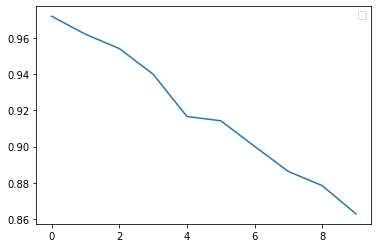

In [25]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.legend()
plt.show()

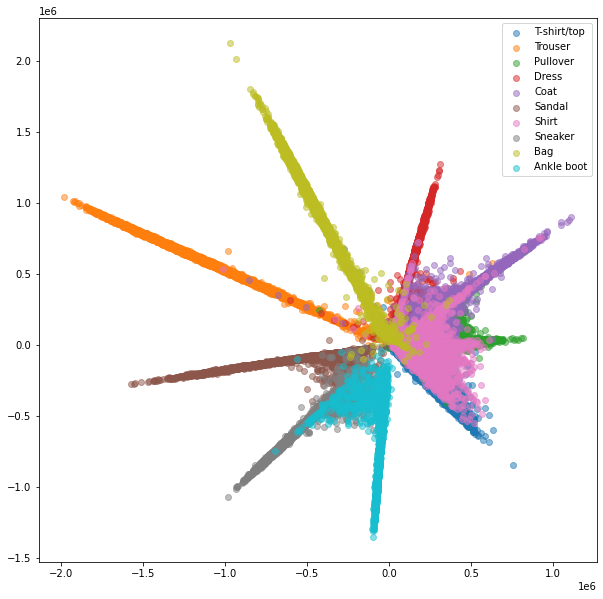

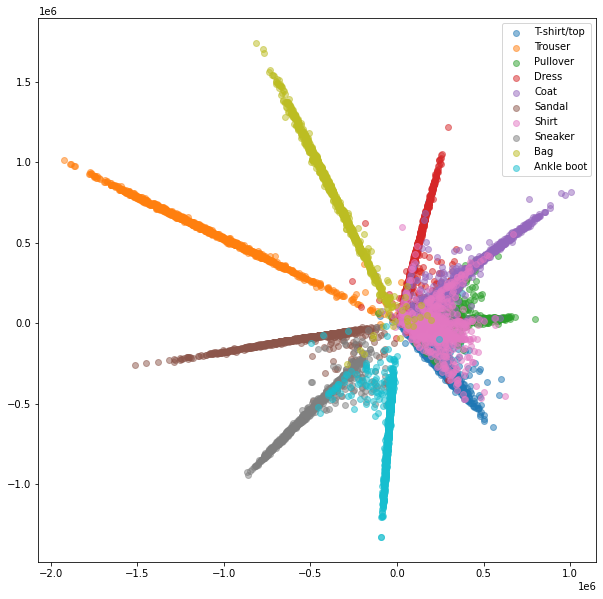

In [26]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [27]:
#Your Code Here


<br>
<span style="color:blue">

**Open Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [28]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the [github repo](https://github.com/DmitryUlyanov/Multicore-TSNE) for info on how to use it. Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few**

</span>

In [29]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=7af0a65ec6d1c87b4450e74803e4227ce167e61be8287f6d53f665f21362d3b3
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [30]:
# Your Code Here
